# Multiple Inputs usage

Example created by Wilson Rocha Lacerda Junior

## Generating 2 input 1 output sample data


The data is generated by simulating the following model:

$y_k = 0.4y_{k-1}^2 + 0.1y_{k-1}x1_{k-1} + 0.6x2_{k-1} -0.3x1_{k-1}x2_{k-2} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.001$


In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data

In [2]:
x_train, x_valid, y_train, y_valid = get_miso_data(
    n=1000,
    colored_noise=False,
    sigma=0.001,
    train_percentage=90
    )

There is a specific difference for multiple input data.

- You have to pass the lags for each input in a nested list (*e.g., [[1, 2], [1, 2]]*)

The remainder settings remains the same.

## Build the model

In [3]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_terms=4,
    extended_least_squares=False,
    ylag=2, xlag=[[1, 2], [1, 2]],
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

In [4]:
model.fit(X=x_train, y=y_train)

## Model evaluation

0.0029846571502489903
       Regressors   Parameters             ERR
0         x2(k-1)   5.9993E-01  9.06513578E-01
1  x2(k-2)x1(k-1)  -3.0018E-01  4.93546372E-02
2        y(k-1)^2   4.0028E-01  4.38045195E-02
3   x1(k-1)y(k-1)   1.0025E-01  3.20226279E-04


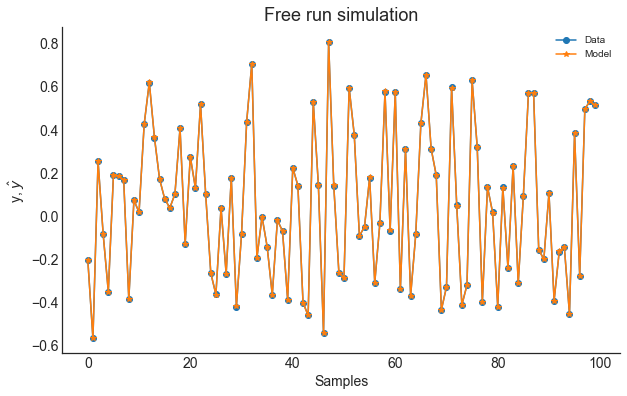

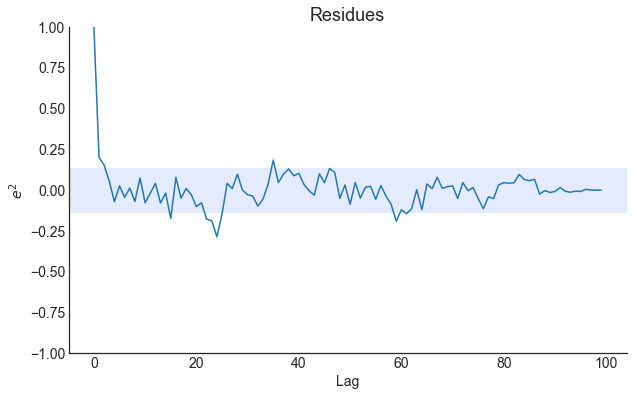

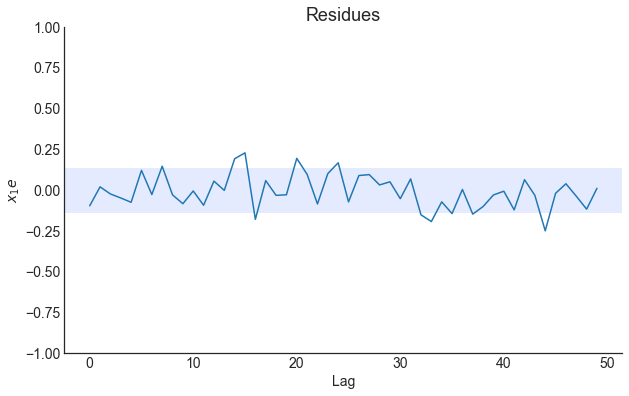

In [5]:
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_valid, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid[:, 0])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

Text(0, 0.5, 'Information Criteria')

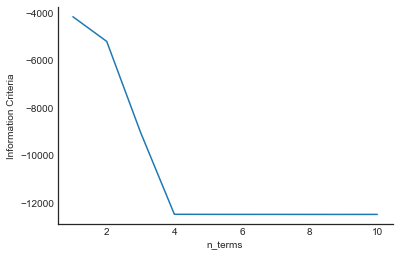

In [6]:
xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel('n_terms')
plt.ylabel('Information Criteria')